In [310]:
import cv2
import numpy as np
from commonfunctions import *
import imutils

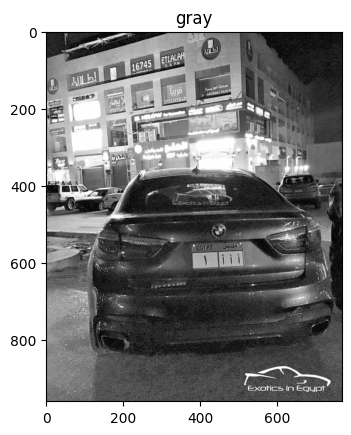

In [311]:
img_path = 'Dataset\\Vehicles\\0187.jpg'
img_color = cv2.imread(img_path)
image = cv2.imread(img_path)  # Load your image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

show_images([gray], ["gray"])

In [312]:
#specify aspect ratio as you want
minAr = 4
maxAr = 5

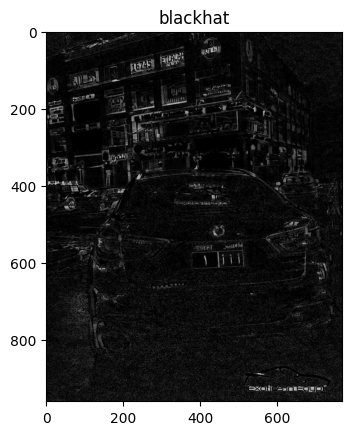

In [313]:
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)

show_images([blackhat], ["blackhat"])

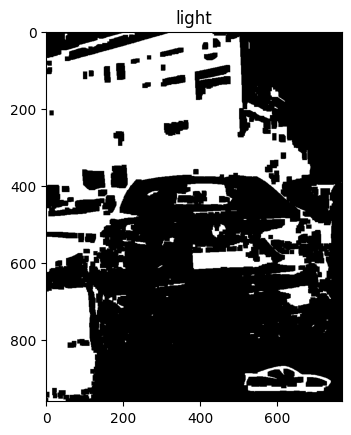

In [314]:
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern, iterations=5)
light = cv2.threshold(light, 0, 255,
		cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
show_images([light], ["light"])

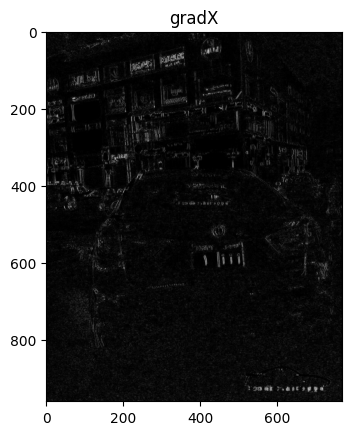

In [315]:
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
			dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")
show_images([gradX], ["gradX"])

In [316]:
# blurred_image = cv2.GaussianBlur(gradX, (5, 5), 1)
# canny = cv2.Canny(blurred_image, 100, 200)
# thresh = cv2.threshold(canny, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# ken = cv2.getStructuringElement(cv2.MORPH_RECT, (5,2))
# thresh2 = cv2.bitwise_and(thresh,thresh,mask=light)
# # thresh2 = cv2.erode(thresh2, None, iterations=2)
# thresh2 = cv2.dilate(thresh2, None, iterations=8)
# thresh2 = cv2.bitwise_and(thresh2,thresh2,mask=light)
# show_images([thresh,thresh2], ["thresh","thresh2"])

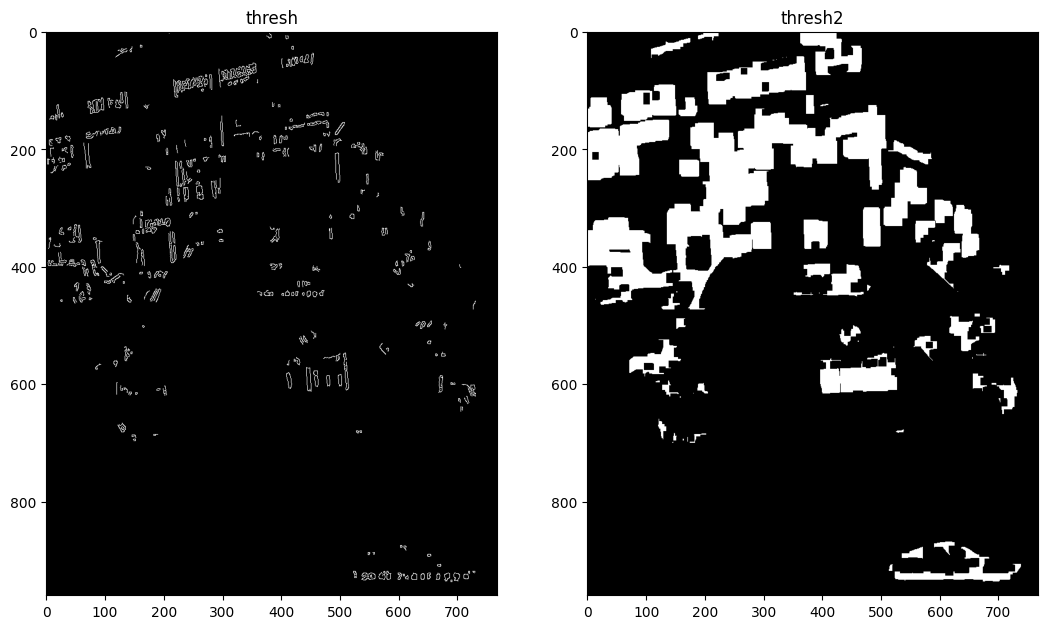

In [317]:
# gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
# gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
# thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# thresh2 = cv2.bitwise_and(thresh, thresh, mask=light)
# thresh2 = cv2.erode(thresh2, None, iterations=3)
# thresh2 = cv2.dilate(thresh2, None, iterations=8)
# thresh2 = cv2.erode(thresh2, None, iterations=1)
# thresh2 = cv2.dilate(thresh2, None, iterations=7)
# thresh2 = cv2.erode(thresh2, None, iterations=1)

# thresh2 = cv2.bitwise_and(thresh2,thresh2,mask=light)
blurred_image = cv2.GaussianBlur(gradX, (5, 5), 1)
canny = cv2.Canny(blurred_image, 100, 200)
thresh = cv2.threshold(canny, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
ken = cv2.getStructuringElement(cv2.MORPH_RECT, (5,2))
thresh2 = cv2.bitwise_and(thresh,thresh,mask=light)
# thresh2 = cv2.erode(thresh2, None, iterations=2)
thresh2 = cv2.dilate(thresh2, None, iterations=12)
thresh2 = cv2.bitwise_and(thresh2,thresh2,mask=light)
show_images([thresh,thresh2], ["thresh","thresh2"])

In [318]:
cnts = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

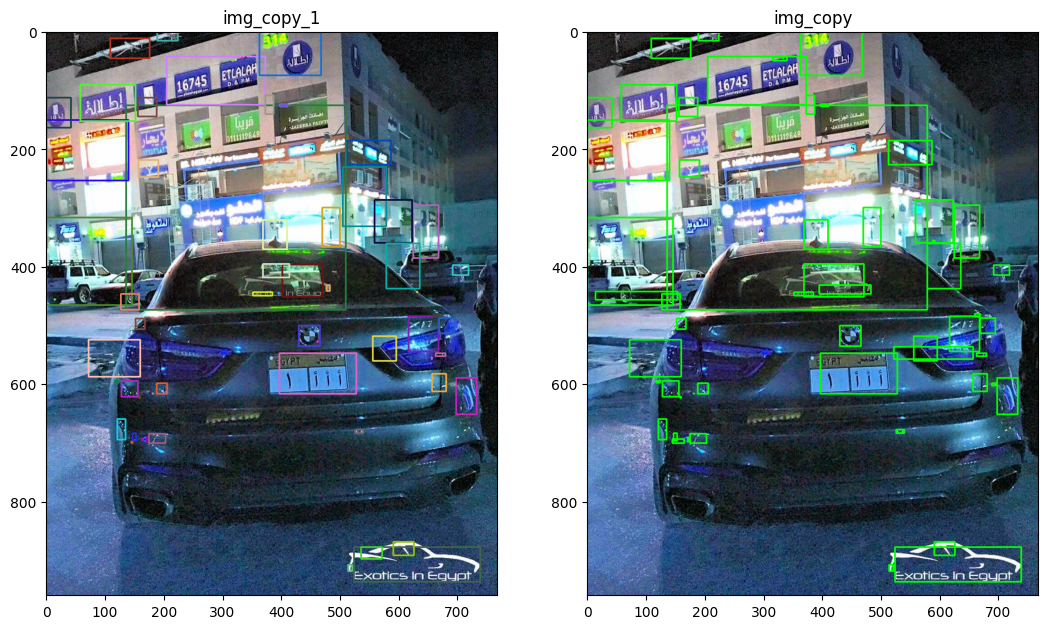

In [319]:
def compute_nearness(rect1,rect2):
    #get colors from original image
    #get the differnece in histograms of the two rectangles
    #get the sum of the differences
    #return the sum
    rect1_img = img_color[rect1[1]:rect1[1]+rect1[3],rect1[0]:rect1[0]+rect1[2]]
    rect2_img = img_color[rect2[1]:rect2[1]+rect2[3],rect2[0]:rect2[0]+rect2[2]]
    hist1 = cv2.calcHist([rect1_img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist2 = cv2.calcHist([rect2_img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    #normalize the histograms to get percentage of each color
    cv2.normalize(hist1, hist1)
    cv2.normalize(hist2, hist2)
    diff = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    return diff
        
    
def merge_rectangles(rectangles):
    for i in range(len(rectangles)):
        for j in range(i+1,len(rectangles)):
            if rectangles[i] and rectangles[j]:
                x1, y1, w1, h1 = rectangles[i]
                x2, y2, w2, h2 = rectangles[j]
                # get mid points of the rectangles
                mid1 = (x1+w1/2,y1+h1/2)
                mid2 = (x2+w2/2,y2+h2/2)
                #if the rectangles are on the same line then merge but with a margin of 15 pixels
                if abs(mid1[1] - mid2[1]) < 20:
                    # calculate the nearness of the rectangles using cost function
                    # they may be not overlapping but near to each other
                    nearness = compute_nearness(rectangles[i],rectangles[j]) 
                    horizontal_distance = abs(mid1[0] - mid2[0])
                    #if (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2):
                    if nearness < 2 or (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2):
                        rectangles[i] = (min(x1,x2),min(y1,y2),max(x1+w1,x2+w2)-min(x1,x2),max(y1+h1,y2+h2)-min(y1,y2))
                        rectangles[j] = None
    return rectangles

# loop over the contours and draw them
img_copy = image.copy()
img_copy_1 = image.copy()
rectangles = []
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    #each contour with a random color and rectangle
    color = np.random.randint(0, 255, size=(3,)).tolist()
    #draw rectangle around the contour
    rectangles.append((x, y, w, h))
    cv2.rectangle(img_copy_1, (x, y), (x + w, y + h), color, 2)
    # cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 2)
#merge overlapping rectangles
# for i in range(len(rectangles)):
#     for j in range(i+1,len(rectangles)):
#         if rectangles[i] and rectangles[j]:
#             x1, y1, w1, h1 = rectangles[i]
#             x2, y2, w2, h2 = rectangles[j]
#             #mid point of the rectangles
#             mid1 = (x1+w1/2,y1+h1/2)
#             mid2 = (x2+w2/2,y2+h2/2)
#             #if horizontal distance between the mid points is less than the sum of the widths
#             #then the rectangles are overlapping
#             # also there centers is at the same height with error margin
#             if abs(mid1[1] - mid2[1]) < 15:
#                 if x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2:
#                     rectangles[i] = (min(x1,x2),min(y1,y2),max(x1+w1,x2+w2)-min(x1,x2),max(y1+h1,y2+h2)-min(y1,y2))
#                     rectangles[j] = None
rectangles = merge_rectangles(rectangles)
for rect in rectangles:
    if rect:
        x, y, w, h = rect
        cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
show_images([img_copy_1,img_copy], ["img_copy_1","img_copy"])

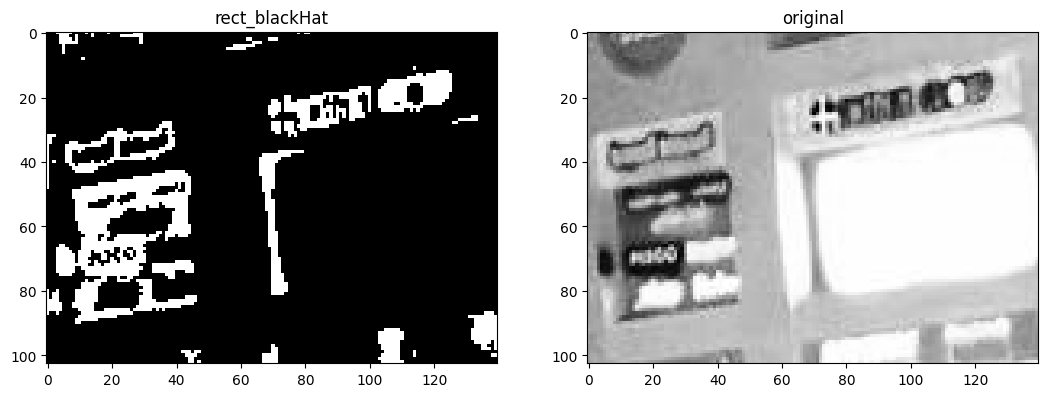

Filtered Rectangles: [(103, 92, 8, 11), (131, 87, 9, 12), (33, 71, 13, 6), (66, 37, 14, 45), (0, 32, 3, 17), (6, 28, 34, 16), (74, 17, 27, 14), (103, 12, 23, 13)]


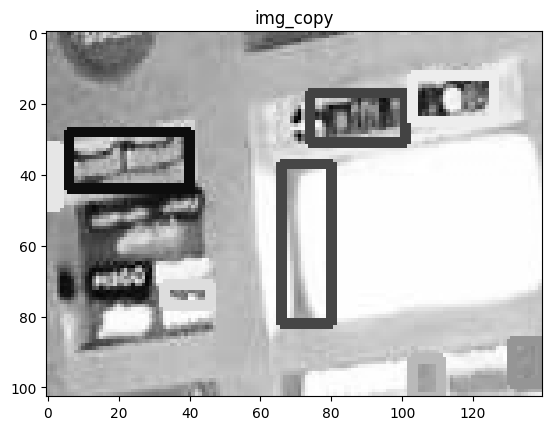

Variance: 811.859375


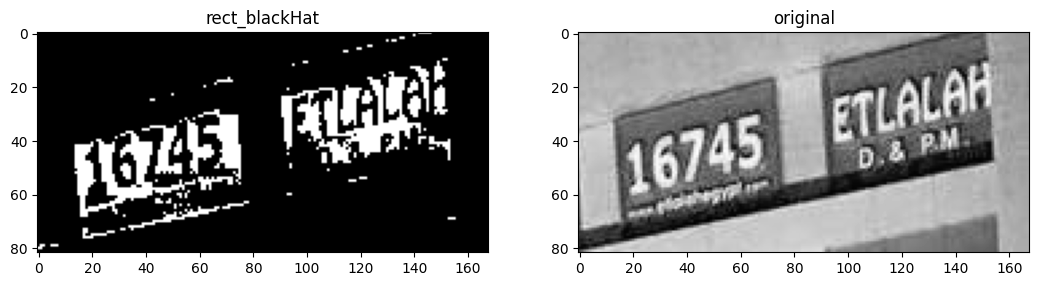

Filtered Rectangles: [(34, 65, 34, 9), (60, 54, 13, 5), (146, 39, 8, 9), (39, 35, 15, 18), (55, 32, 11, 21), (60, 29, 16, 28), (148, 20, 5, 11), (113, 20, 8, 15), (139, 13, 7, 17)]


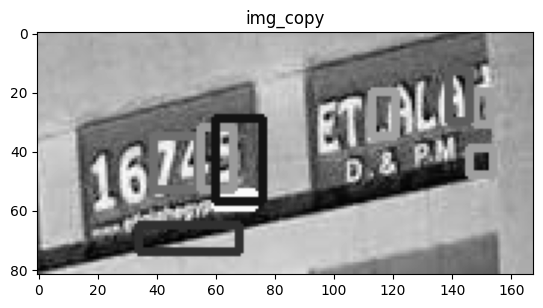

Variance: 208.27777777777777


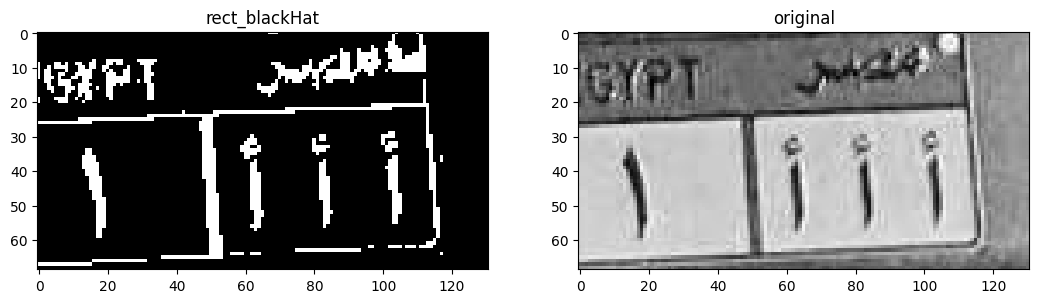

Filtered Rectangles: [(0, 66, 32, 2), (82, 37, 4, 20), (62, 37, 4, 21), (101, 36, 5, 20), (13, 34, 7, 26), (29, 8, 6, 12), (19, 8, 8, 12), (5, 8, 12, 13), (64, 4, 36, 15), (101, 0, 12, 12)]


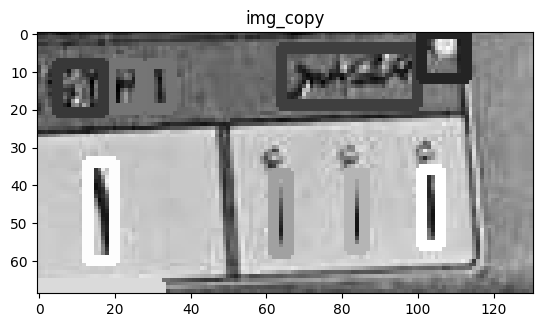

Variance: 415.87250000000006


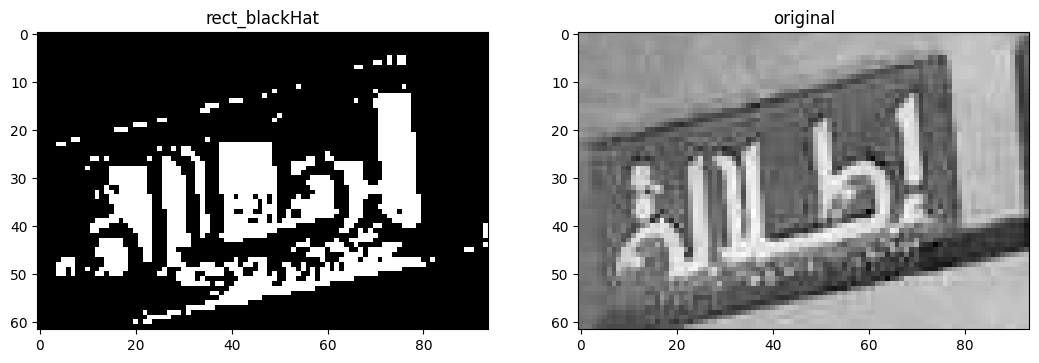

Filtered Rectangles: [(12, 43, 7, 8), (11, 28, 13, 20), (30, 24, 6, 19), (38, 23, 25, 21), (60, 12, 20, 30)]


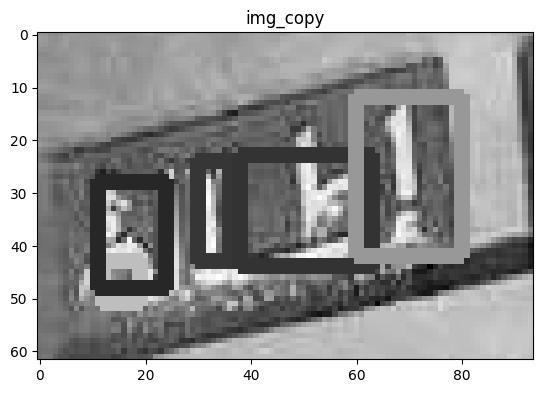

Variance: 43.660000000000004


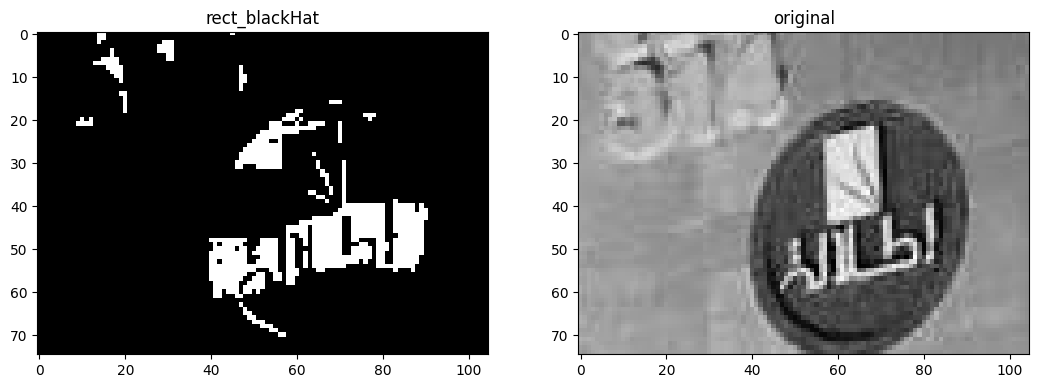

Filtered Rectangles: [(47, 63, 11, 8), (40, 48, 17, 14), (58, 30, 33, 29), (46, 18, 21, 14), (13, 4, 7, 8)]


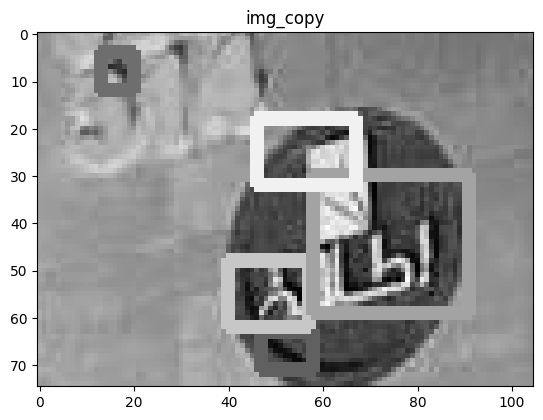

Variance: 444.64


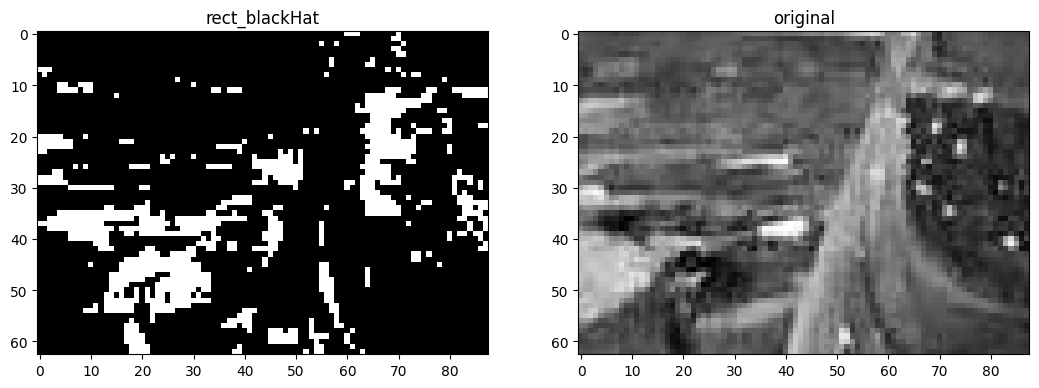

Filtered Rectangles: [(55, 45, 5, 13), (42, 34, 6, 12), (81, 27, 7, 16), (0, 27, 15, 4), (42, 23, 10, 8), (62, 11, 16, 25)]


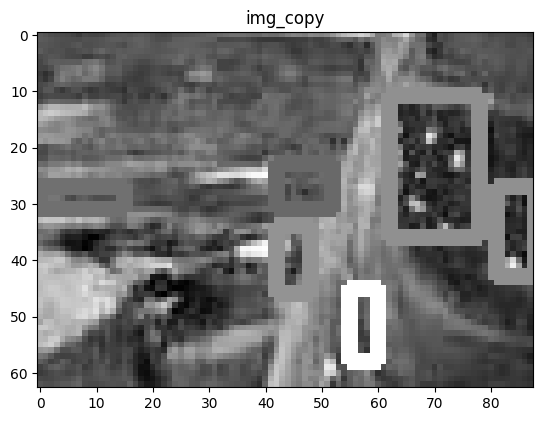

Variance: 87.80555555555556


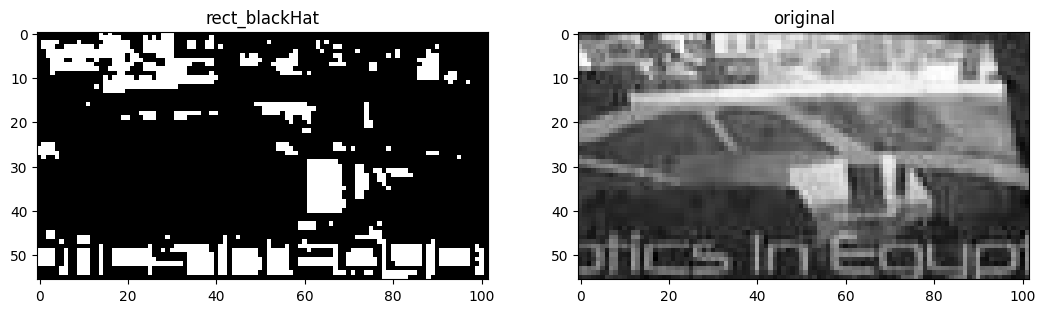

Filtered Rectangles: [(30, 48, 10, 7), (17, 48, 16, 7), (59, 47, 11, 8), (72, 44, 14, 12), (61, 29, 9, 12), (49, 16, 14, 5), (1, 0, 40, 14)]


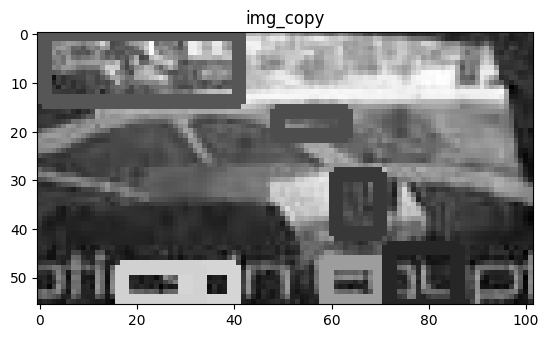

Variance: 289.63265306122446


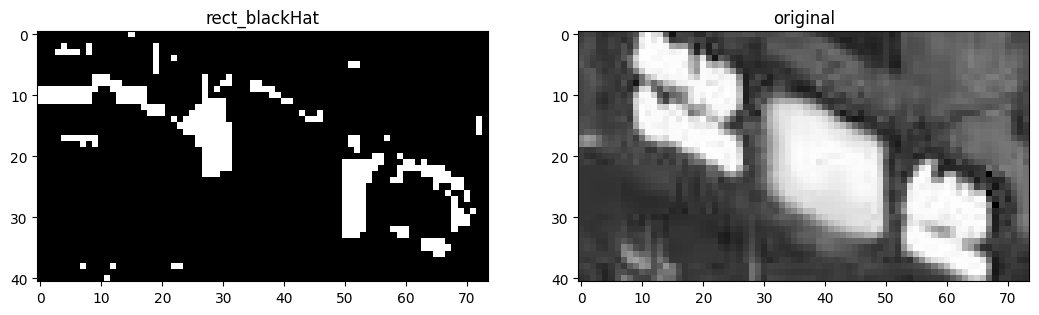

Filtered Rectangles: [(58, 20, 14, 13), (50, 20, 7, 14), (22, 7, 10, 17), (0, 7, 21, 7)]


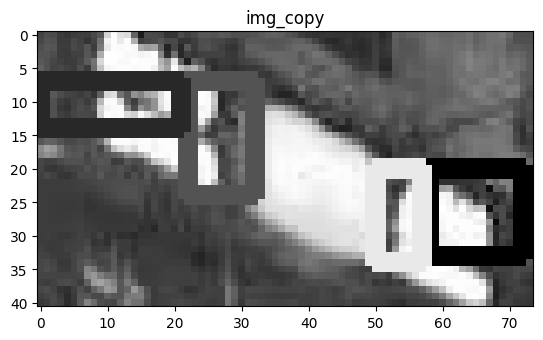

Variance: 50.421875


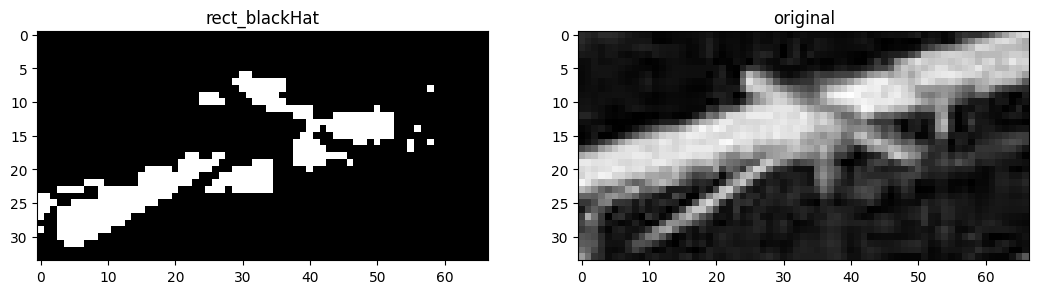

Filtered Rectangles: [(0, 18, 28, 14), (29, 6, 24, 15)]


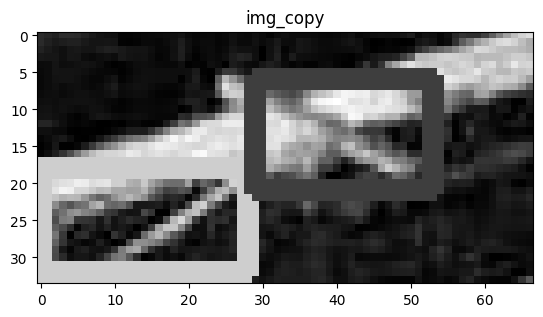

Variance: 33.0625


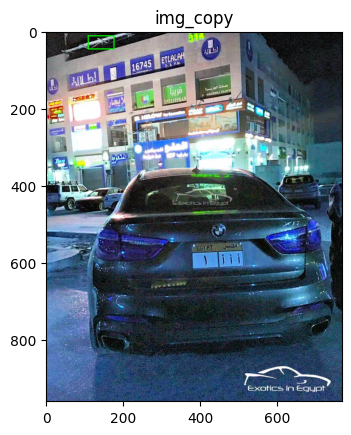

Plate coordinates relative to image width and height
x: 0.14192708333333334 y: 0.0125 w: 0.08723958333333333 h: 0.035416666666666666


In [327]:
# Find contours inside each region.
# Find bounding rectangle around each contour.
# delete very small or very larg rectangle.
# Check weather these contours are represent a straight line. The region with contours that are arranged in linear way is the plate.

def get_plate_variance(rectangle):
        x, y, w, h = rectangle
        img_copy = gray[y:y+h, x:x+w]
        rect_blackHat = blackhat[y:y+h, x:x+w]
        rect_blackHat = cv2.threshold(
            rect_blackHat, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        show_images([rect_blackHat,img_copy], ["rect_blackHat","original"])
        cnts = cv2.findContours(rect_blackHat.copy(),
                                cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts_filtered = []
        filtered_rectangles = []

        # delete very small or very large rectangle.
        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            area = w*h
            if area > 50 and area < 1000:
                filtered_rectangles.append((x, y, w, h))
        if len(filtered_rectangles) < 2:
            return 1000
        
        vertical_centers = []
        print("Filtered Rectangles:",filtered_rectangles)
        for rect in filtered_rectangles:
            x, y, w, h = rect
            vertical_centers.append(y+h/2)
            color = np.random.randint(0, 255, size=(3,)).tolist()
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 2)
        variance = np.var(vertical_centers)
        show_images([img_copy], ["img_copy"])
        print("Variance:",variance)
        if (len(filtered_rectangles) < 2):
            variance = 1000
        return variance

plate = None
# specify the aspect ratio of the plate to be detected from the rectangles
img_copy_2 = image.copy()
candidate_rectangles = []
for rect in rectangles:
    if rect:
        x, y, w, h = rect
        ar = w / float(h)
        area = w*h
        if ar >= 1.3 and ar <= 3 and area > 1000:
            var = get_plate_variance(rect)
            candidate_rectangles.append((var,rect))   
            # plate = rect
            # img_copy_2 = image.copy()
            # cv2.rectangle(img_copy_2, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # break
            # show_images([img_copy_2], ["img_copy"])
sortedRects = sorted(candidate_rectangles, key=lambda x: x[0])
if len(sortedRects):
    x, y, w, h = sortedRects[0][1]
    cv2.rectangle(img_copy_2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    show_images([img_copy_2], ["img_copy"])
    
    #print pixel coordinates of the plate but relative to width and height of the image
    
    print("Plate coordinates relative to image width and height")
    print("x:",x/image.shape[1],"y:",y/image.shape[0],"w:",w/image.shape[1],"h:",h/image.shape[0])